In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5py
from umda.smi_vec import inchi_to_smiles, load_model, smi_to_vector
# import umap.plot
from umap import UMAP

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.style.use("publication")

Traceback (most recent call last):
  File "/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


In [2]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [3]:
data.keys()

<KeysViewHDF5 ['cluster_ids', 'pca', 'smiles', 'vectors']>

In [4]:
manifold_model = UMAP(n_neighbors=20, n_components=2, random_state=42, metric="cosine")

In [6]:
indices = np.arange(len(data["vectors"]))

rng = np.random.default_rng(42)

chosen = rng.choice(indices, 30000, replace=False)
chosen.sort()

In [7]:
# loading data in a non-contiguous way takes a damn long time
vectors = data["vectors"][:,:]

In [8]:
manifold_model.fit(vectors[chosen])

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=20, random_state=42)

In [9]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

tmc1_vecs = np.vstack(tmc1_df["Vecs"])

In [10]:
tmc1_embedding = manifold_model.transform(tmc1_vecs)

## Get KIDA embeddings

In [11]:
kida_df = pd.read_csv("../../data/external/kida-molecules_05_Jul_2020.csv")

In [12]:
kida_smi = kida_df["InChI"].apply(inchi_to_smiles).to_list()

In [13]:
kida_smi = [smi for smi in kida_smi if smi]

In [14]:
m2v_model = load_model("../../models/mol2vec_model.pkl")

In [15]:
kida_vectors = list()
for smi in kida_smi:
    try:
        vec = smi_to_vector(smi, m2v_model)
        if vec.sum() != 0.:
            kida_vectors.append(vec)
    except:
        pass

In [16]:
kida_vectors = np.vstack(kida_vectors)

kida_embedding = manifold_model.transform(kida_vectors)

In [17]:
kida_embedding[456]

array([-1.0823877,  9.132227 ], dtype=float32)

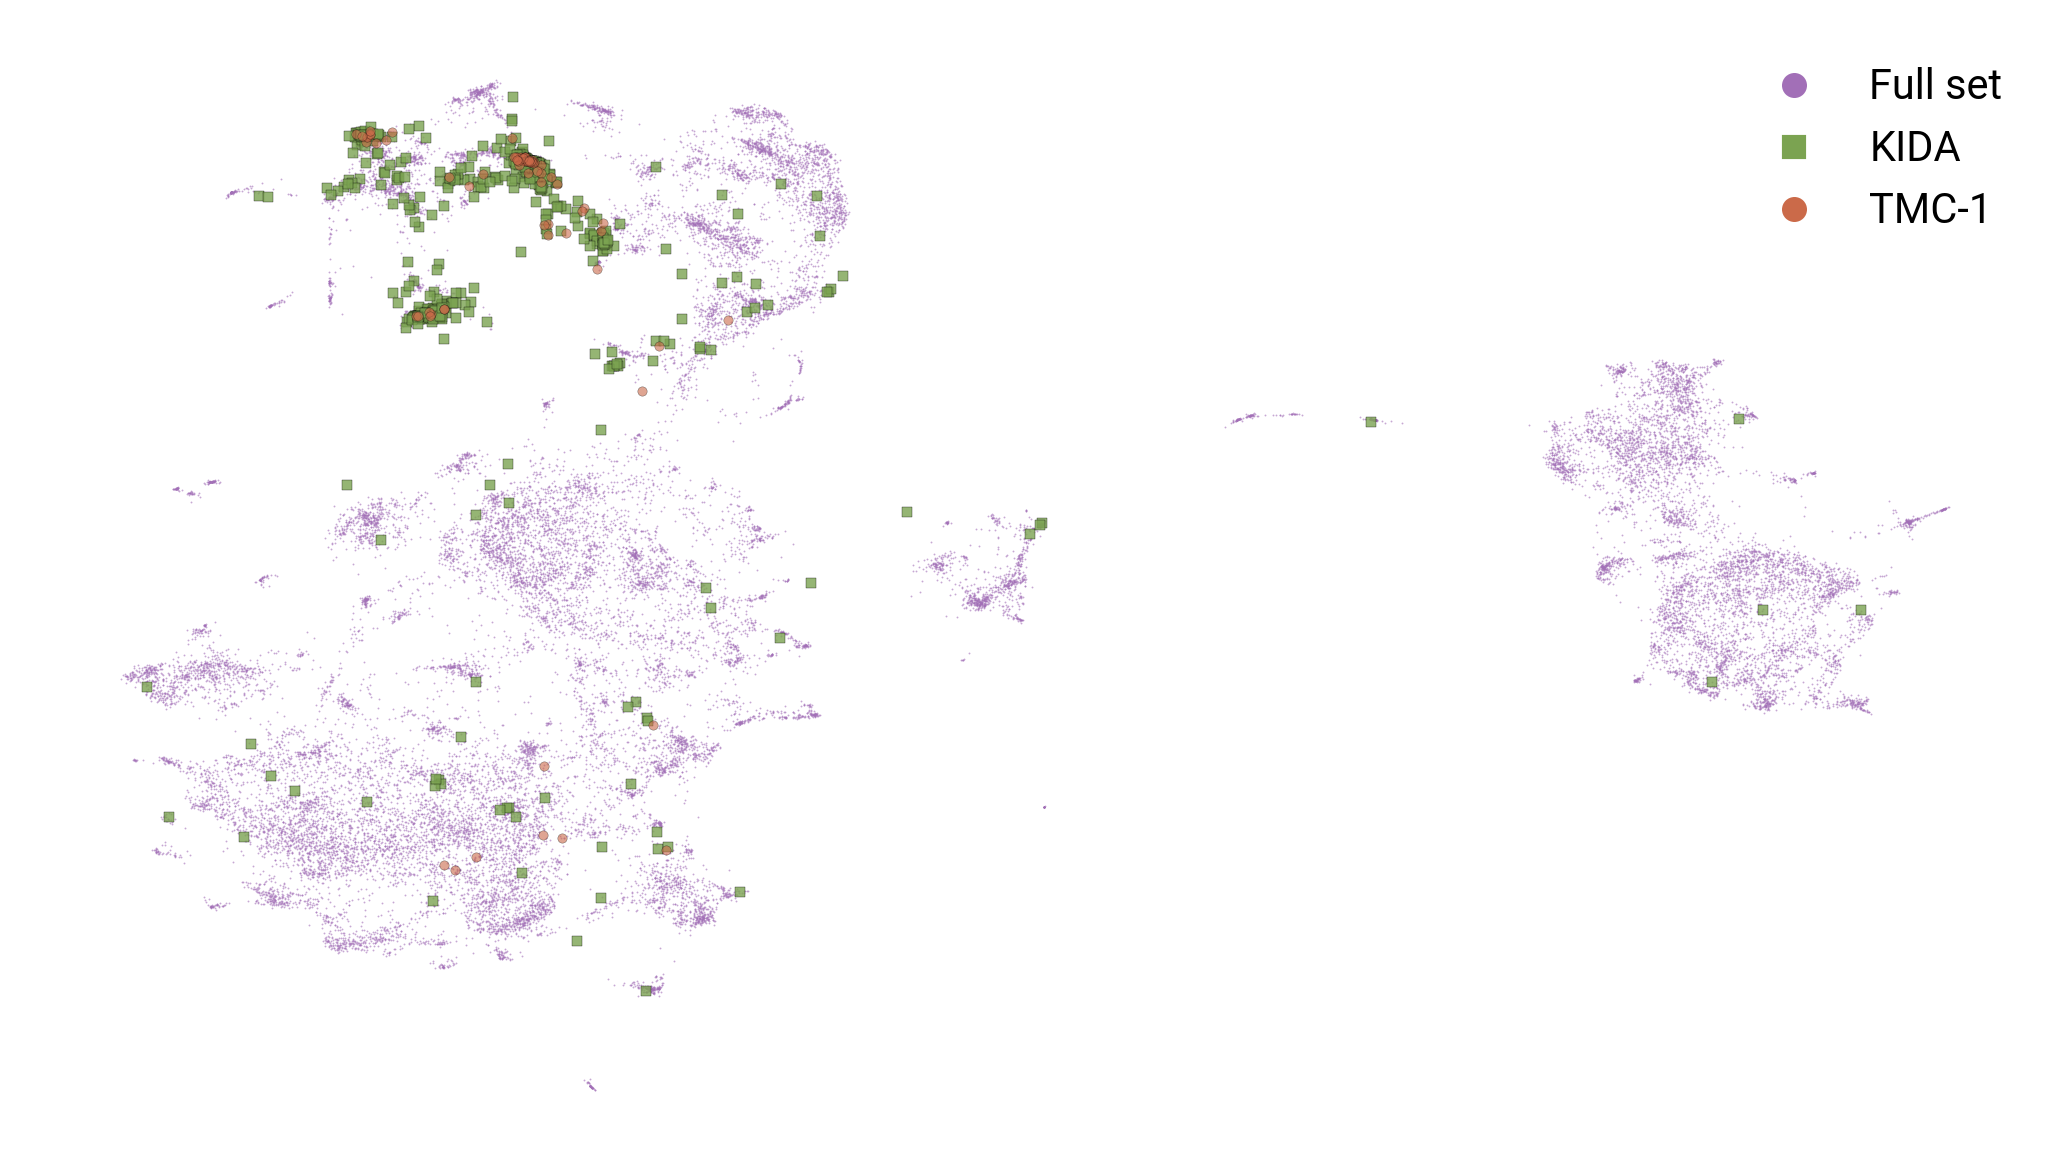

In [48]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(manifold_model.embedding_[:,0], manifold_model.embedding_[:,1], s=0.2, alpha=0.6, lw=0., color="#a26fb7")
ax.scatter(kida_embedding[:,0], kida_embedding[:,1], s=5, alpha=0.8, lw=0.1, color="#7ba351", edgecolors="k", label="KIDA", marker="s")
ax.scatter(tmc1_embedding[:,0], tmc1_embedding[:,1], s=5, alpha=0.6, lw=0.1, color="#cb6a49", edgecolors="k", label="TMC-1")
ax.set(xticks=[], yticks=[])
# ax.set_facecolor("k")
handles = [
    Line2D([0], [0], color="#a26fb7", label="Full set", lw=0., marker='o'),
    Line2D([0], [0], color="#7ba351", label="KIDA", lw=0., marker='s'),
    Line2D([0], [0], color="#cb6a49", label="TMC-1", lw=0., marker='o')
]
legend = ax.legend(handles=handles)
# for text in legend.get_texts():
#     plt.setp(text, color = 'w')
for spine in ax.spines.values():
    spine.set_visible(False)

fig.savefig("../../reports/figures/umap_all_mols.pdf", dpi=100)
fig.savefig("../../reports/figures/umap_all_mols.svg", dpi=150, transparent=True)

In [32]:
mask = np.logical_and(tmc1_embedding < 1., tmc1_embedding > -3.).all(axis=1)

In [34]:
tmc1_df.loc[mask]

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,Vecs
8,Cyclopropa-1-yne-3-ylradical,C3H,C1=C=C1,3.020000e+13,10.3847/0067-0049/225/2/27,0,0,Kaifu survey obs,"[1.312082, -0.7090143, -0.7616991, 0.6230702, ..."
10,Cyclopropyne,C3H2,C1=CC=1,5.890000e+11,10.3847/0067-0049/225/2/29,0,0,Kaifu survey obs,"[1.3120819, -0.7090143, -0.7616991, 0.6230702,..."
22,Sulfur monoxide,SO,O=S,4.680000e+13,10.3847/0067-0049/225/2/40,0,0,Kaifu survey obs,"[0.018443452, 0.32407147, -0.26382357, 0.31939..."
32,Carbonyl sulfide,OCS,O=C=S,1.820000e+13,10.3847/0067-0049/225/2/51,0,0,Kaifu survey obs,"[1.1530113, -0.4521287, -1.2925968, 1.6387094,..."
63,1-cyanonaphthalene,C11H7N,N#CC1=CC=CC2=CC=CC=C12,7.350000e+11,NaN,0,0,GOTHAM; McGuire 2020,"[1.5101533, -0.4900634, -1.9548997, -1.1460742..."
64,2-cyanonaphthalene,C11H7N,N#CC1C=CC2=CC=CC=C2C=1,7.050000e+11,NaN,0,0,GOTHAM; McGuire 2020,"[1.7355971, -0.9354336, -1.758426, -0.9423655,..."
65,Benzonitrile,C6H5CN,N#CC1C=CC=CC=1,1.730000e+12,NaN,0,0,GOTHAM; McGuire 2020,"[0.6859226, -1.5942088, -1.2350538, -1.3747207..."
97,NaN,H2C3O,O=C1=CC=1,4.000000e+11,10.1051/0004-6361/202039364,0,0,Yebes,"[0.38198322, 0.6545495, -0.71283895, -0.154509..."


In [36]:
tmc1_embedding[mask]

array([[-0.38967997, -1.6670591 ],
       [-0.1967999 , -1.7164526 ],
       [ 0.72656465,  0.182597  ],
       [ 0.8559956 , -1.9233273 ],
       [-1.060157  , -2.051762  ],
       [-1.2735474 , -2.267743  ],
       [-1.3835849 , -2.1803565 ],
       [-0.37038806, -0.49934286]], dtype=float32)

In [39]:
np.where(mask == True)

(array([ 7,  9, 21, 31, 45, 46, 47, 76]),)